<a href="https://colab.research.google.com/github/Vasanthan250703/Titanic-Survival-Prediction/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris  # Not needed for Titanic dataset; optional
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA  # Optional
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


### Load the Titanic data Set



In [2]:
titanic=sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### **Select Relevant Features and the Target**

In [3]:
titanic.count()

,0
survived,891
pclass,891
sex,891
age,714
sibsp,891
parch,891
fare,891
embarked,889
class,891
who,891


### **Features to Drop**

The deck column contains too many missing values, so it will be dropped. While age also has several missing entries, it may be handled differently. The embarked and embark_town columns don't appear relevant to survival prediction and will be removed. The alive column is unclear and will be ignored.

In [10]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

# Extract features and target
X = titanic[features]
y = titanic[target]

In [11]:
#Balance the classes
y.value_counts()

,count
survived,
0,549
1,342


### **Split the Data for Training and Testing Sets**

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [13]:
# Detect numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Display the results
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical Features: ['sex', 'class', 'who']


## Preprocessing Transformers for Numerical and Categorical

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [15]:
# Combine both pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Creating a Model Pipeline

In [16]:
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

## Parameter Grid

In [17]:
param_grid = {
    'classifier__n_estimators': [50, 100],       # Number of trees
    'classifier__max_depth': [None,10, 20],       # Max depth of trees
    'classifier__min_samples_split': [2, 5]        # Minimum samples at a leaf node
}

## Performing GridSearchCV to find the best Model to the training Data

In [19]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(model_pipeline, param_grid, cv=stratified_cv, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['pclass',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'class',
                                                                          'who'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             verbose=2)

In [21]:
#Model Predictions from Grid Search Estimator on Unseen Data
y_pred=grid_search.predict(X_test);
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



### **Confusion Matrix**

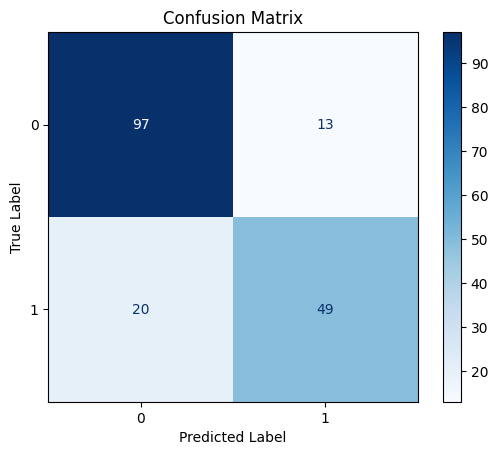

In [22]:
cm = confusion_matrix(y_test, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')  # This is the actual label
plt.show()

<ipython-input-23-dbe3de39f232>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')


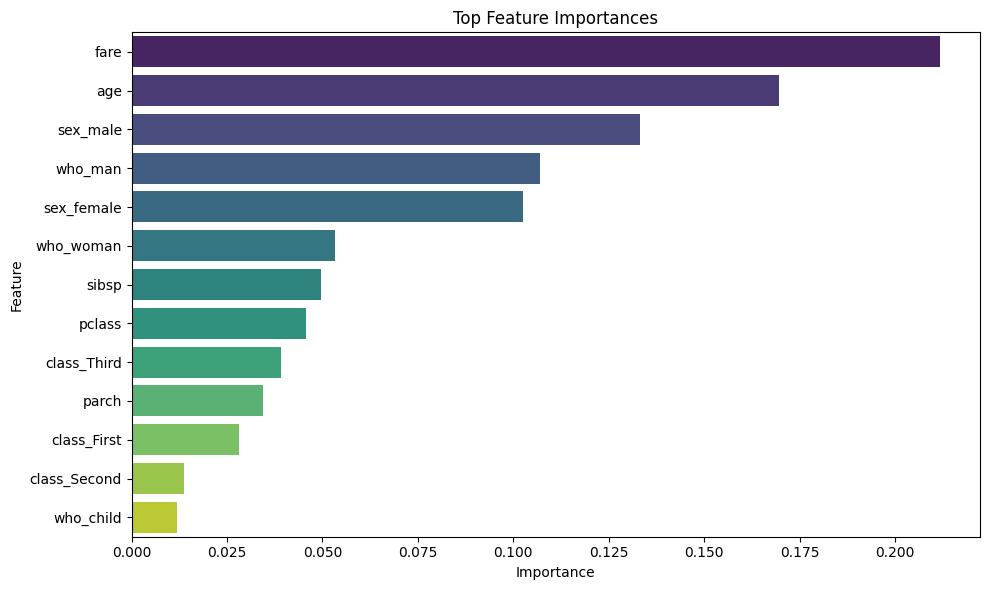

In [23]:
# Get trained model
best_model = grid_search.best_estimator_

# Step 1: Get transformed feature names
# - Numerical features: unchanged
# - Categorical features: one-hot encoded

# Get one-hot encoded feature names
onehot = best_model.named_steps['preprocessing'].named_transformers_['cat'].named_steps['encoder']
onehot_feature_names = onehot.get_feature_names_out(categorical_features)

# Combine with numeric feature names
all_feature_names = numeric_features + list(onehot_feature_names)

# Step 2: Get feature importances from classifier
importances = best_model.named_steps['classifier'].feature_importances_

# Step 3: Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 4: Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()


In [24]:
#Test Score

In [25]:
test_Score=grid_search.score(X_test,y_test)
print(f"Test Score: {test_Score}")

Test Score: 0.8156424581005587


In [29]:
# Replace the classifier in the pipeline
model_pipeline.set_params(classifier=LogisticRegression(random_state=42, max_iter=1000))

# New parameter grid for Logistic Regression
param_grid_logreg = {
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Create new GridSearchCV with updated pipeline and param grid
grid_search_logreg = GridSearchCV(model_pipeline, param_grid_logreg, cv=stratified_cv, n_jobs=-1, verbose=2)

grid_search_logreg.fit(X_train, y_train)

y_pred = grid_search_logreg.predict(X_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

In [31]:
from sklearn.metrics import classification_report
print("Best Params:", grid_search_logreg.best_params_)
print(classification_report(y_test, y_pred))

Best Params: {'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



## Confusion matrix for Logistic Regression Model

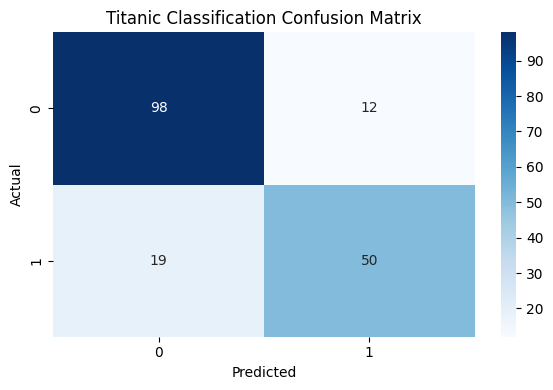

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
#Coefficients from trained logistic regression model
coefficients = grid_search_logreg.best_estimator_.named_steps['classifier'].coef_[0]  # shape: (n_features,)

#feature names
numerical_feature_names = numeric_features

categorical_feature_names = grid_search_logreg.best_estimator_ \
    .named_steps['preprocessing'] \
    .named_transformers_['cat'] \
    .named_steps['encoder'] \
    .get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = numerical_feature_names + list(categorical_feature_names)

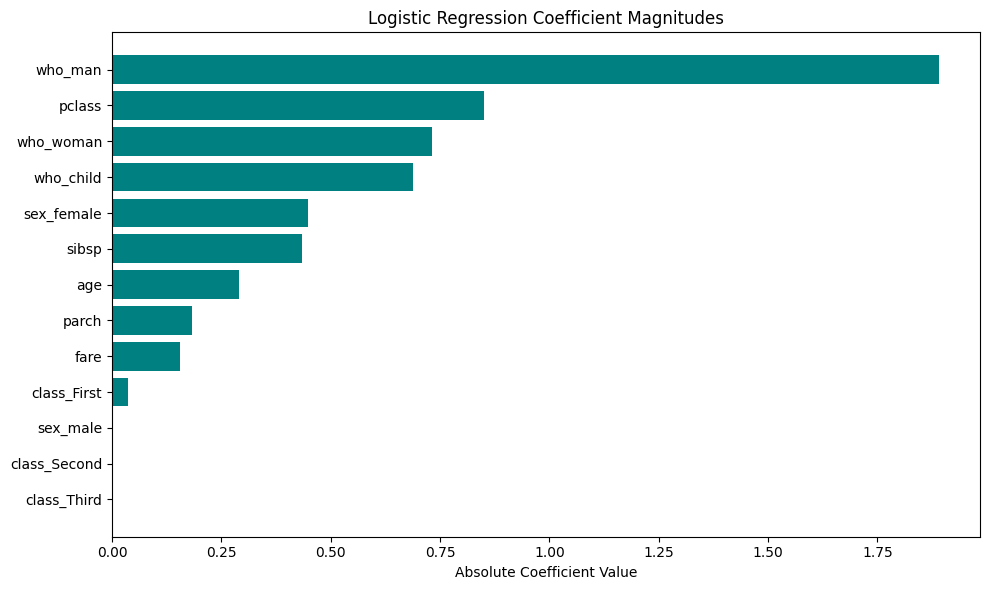

In [36]:
# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
importance_df = importance_df.reindex(importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='teal')
plt.title('Logistic Regression Coefficient Magnitudes')
plt.xlabel('Absolute Coefficient Value')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [37]:
# Print test accuracy score
test_score = grid_search_logreg.score(X_test, y_test)
print(f"Test Accuracy: {test_score:.4f}")


Test Accuracy: 0.8268


### Considering the Other Models Too

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

### XGBoost Model

In [39]:
from xgboost import XGBClassifier

# Building pipeline with XGB
model_pipeline.set_params(classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))

# Hyperparameter grid
param_grid_xgb = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_depth': [3, 5]
}

# GridSearchCV
grid_xgb = GridSearchCV(model_pipeline, param_grid_xgb, cv=stratified_cv, n_jobs=-1, verbose=2)
grid_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = grid_xgb.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:18:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Evaluating XGBoost

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



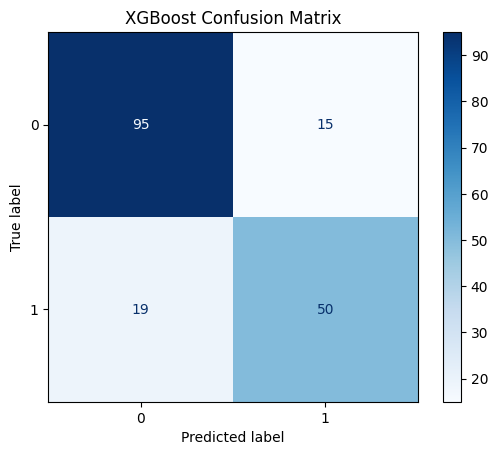

In [40]:
print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()


# SVC Model

In [41]:
from sklearn.svm import SVC

model_pipeline.set_params(classifier=SVC(probability=True, random_state=42))

param_grid_svc = {
    'classifier__C': [0.1, 1],
    'classifier__kernel': ['linear', 'rbf']
}

grid_svc = GridSearchCV(model_pipeline, param_grid_svc, cv=stratified_cv, n_jobs=-1, verbose=2)
grid_svc.fit(X_train, y_train)

y_pred_svc = grid_svc.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


## Evaluating SVC

SVC Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       110
           1       0.82      0.72      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



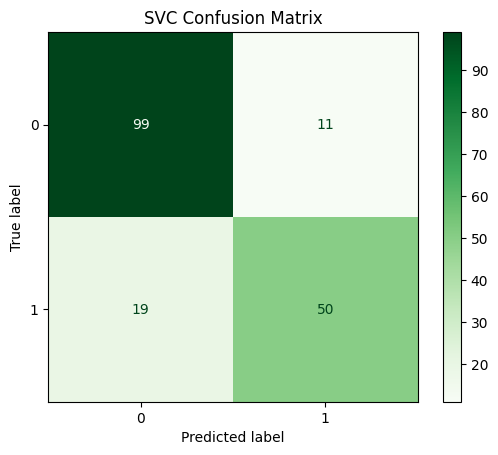

In [42]:
print("SVC Classification Report")
print(classification_report(y_test, y_pred_svc))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, cmap='Greens')
plt.title("SVC Confusion Matrix")
plt.show()


### Gradient Boosting Classifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

model_pipeline.set_params(classifier=GradientBoostingClassifier(random_state=42))

param_grid_gb = {
    'classifier__n_estimators': [100, 150],
    'classifier__learning_rate': [0.1, 0.05]
}

grid_gb = GridSearchCV(model_pipeline, param_grid_gb, cv=stratified_cv, n_jobs=-1, verbose=2)
grid_gb.fit(X_train, y_train)

y_pred_gb = grid_gb.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


## Evaluate Gradient Boosting

Gradient Boosting Classification Report
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       110
           1       0.82      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



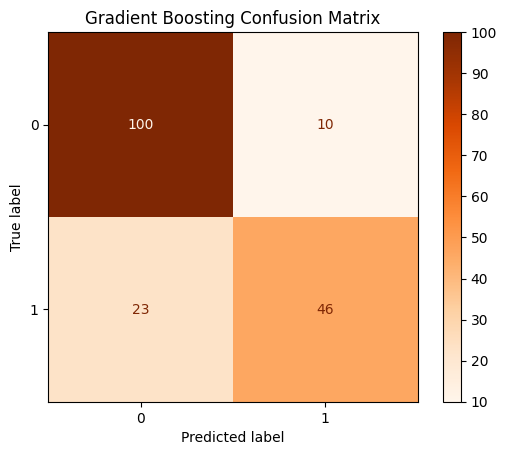

In [44]:
print("Gradient Boosting Classification Report")
print(classification_report(y_test, y_pred_gb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, cmap='Oranges')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


## KNN Model

In [45]:
from sklearn.neighbors import KNeighborsClassifier

model_pipeline.set_params(classifier=KNeighborsClassifier())

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7]
}

grid_knn = GridSearchCV(model_pipeline, param_grid_knn, cv=stratified_cv, n_jobs=-1, verbose=2)
grid_knn.fit(X_train, y_train)

y_pred_knn = grid_knn.predict(X_test)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


Evaluating KNN Model

KNN Classification Report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



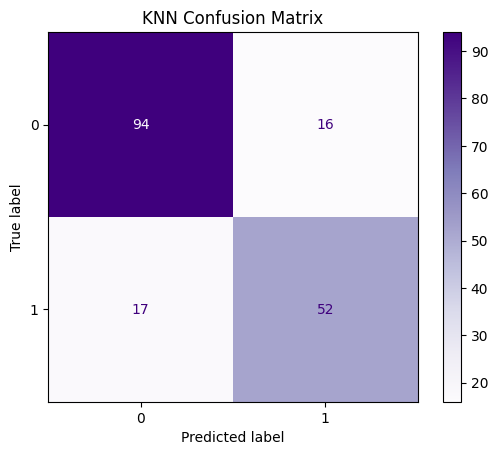

In [46]:
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Purples')
plt.title("KNN Confusion Matrix")
plt.show()


In [49]:
print("✅ Model Accuracy Comparison:")
print("Random Forest:", grid_search.score(X_test, y_test))
print("Logistic Regression:", grid_search_logreg.score(X_test, y_test))
print("XGBoost:", grid_xgb.score(X_test, y_test))
print("SVC:", grid_svc.score(X_test, y_test))
print("Gradient Boosting:", grid_gb.score(X_test, y_test))
print("KNN:", grid_knn.score(X_test, y_test))


✅ Model Accuracy Comparison:
Random Forest: 0.8156424581005587
Logistic Regression: 0.8268156424581006
XGBoost: 0.8100558659217877
SVC: 0.8324022346368715
Gradient Boosting: 0.8156424581005587
KNN: 0.8156424581005587


## ROC-AUC Curves for All Models

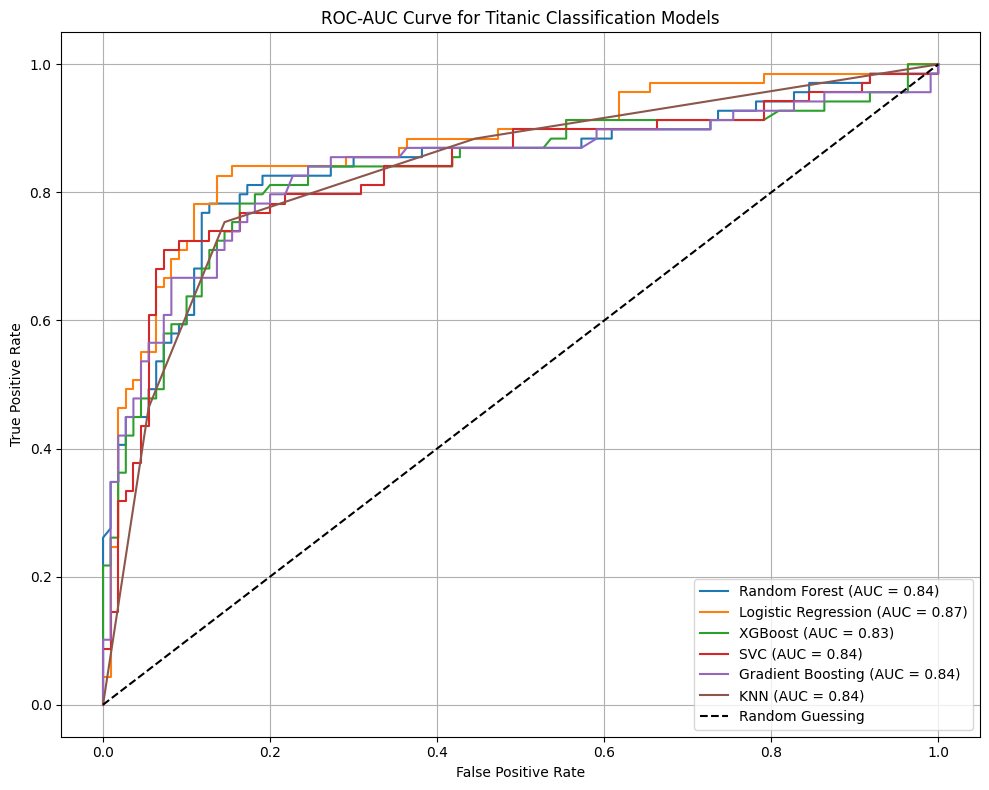

In [51]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# List of trained models and their names
models = [
    ('Random Forest', grid_search),
    ('Logistic Regression', grid_search_logreg),
    ('XGBoost', grid_xgb),
    ('SVC', grid_svc),
    ('Gradient Boosting', grid_gb),
    ('KNN', grid_knn)
]

plt.figure(figsize=(10, 8))

for name, model in models:
    # Predict probabilities or decision function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC Curve baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Plot settings
plt.title('ROC-AUC Curve for Titanic Classification Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
